<a href="https://colab.research.google.com/github/pangtengg/Garbage-Classification-ResNet50/blob/main/Garbage_Classification_ResNet50%20final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garbage Classification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://www.kaggle.com/datasets/126ab2c7f7e22add276bc29e44b97f635e3f6a04368afb20130a83518a9056b9

In [3]:
!pip install torchsummary

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm

Configuration

In [5]:
image_size = 224
batch_size = 32
num_workers = 2
learning_rate = 1e-5
num_epoch = 10

Data Loading

In [7]:
# Load the dataset
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/garbage_classification')

Splitting Data into Training and Testing Set

In [8]:
pip install scikit-learn

In [9]:
# Get the image paths and corresponding labels
image_paths = np.array([sample[0] for sample in dataset.samples])
labels = np.array([sample[1] for sample in dataset.samples])

# Perform stratified train-val split (80% train, 20% val)
train_idx, val_idx = train_test_split(
    np.arange(len(labels)), test_size=0.2, stratify=labels)

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),  # Data Augmentation
    transforms.RandomRotation(10),      # Data Augmentation
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

In [11]:
train_set = torch.utils.data.Subset(dataset, train_idx)
train_set.dataset.transform = train_transform

val_set = torch.utils.data.Subset(dataset, val_idx)
val_set.dataset.transform = val_transform

In [12]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

In [13]:
print(f'Training set size: {len(train_set)}')
print(f'Test set size: {len(val_set)}')

# Function to count samples per class
def count_samples_per_class(dataset):
    labels = [label for _, label in dataset]
    label_count = Counter(labels)
    return label_count

Training set size: 12412
Test set size: 3103


In [14]:
# label_count = count_samples_per_class(train_set)
# num_classes = len(label_count)
# print("Total number of data: ", len(train_set))
# print("Number of classes:", num_classes)
# print("Number of data samples per class:", label_count)

In [15]:
# label_count = count_samples_per_class(val_set)
# num_classes = len(label_count)
# print("Total number of data: ", len(val_set))
# print("Number of classes:", num_classes)
# print("Number of data samples per class:", label_count)

Dataset Visualisation

In [16]:
from collections import Counter

# Count the distribution of classes in the training set
train_labels = [dataset.targets[i] for i in train_idx]
train_class_counts = Counter(train_labels)

# Count the distribution of classes in the test set
val_labels = [dataset.targets[i] for i in val_idx]
val_class_counts = Counter(val_labels)

print(f'Training set class distribution: {train_class_counts}')
print(f'Test set class distribution: {val_class_counts}')

Training set class distribution: Counter({4: 4260, 9: 1582, 7: 840, 1: 788, 0: 756, 3: 713, 8: 692, 11: 620, 6: 615, 10: 557, 5: 503, 2: 486})
Test set class distribution: Counter({4: 1065, 9: 395, 7: 210, 1: 197, 0: 189, 3: 178, 8: 173, 11: 155, 6: 154, 10: 140, 5: 126, 2: 121})


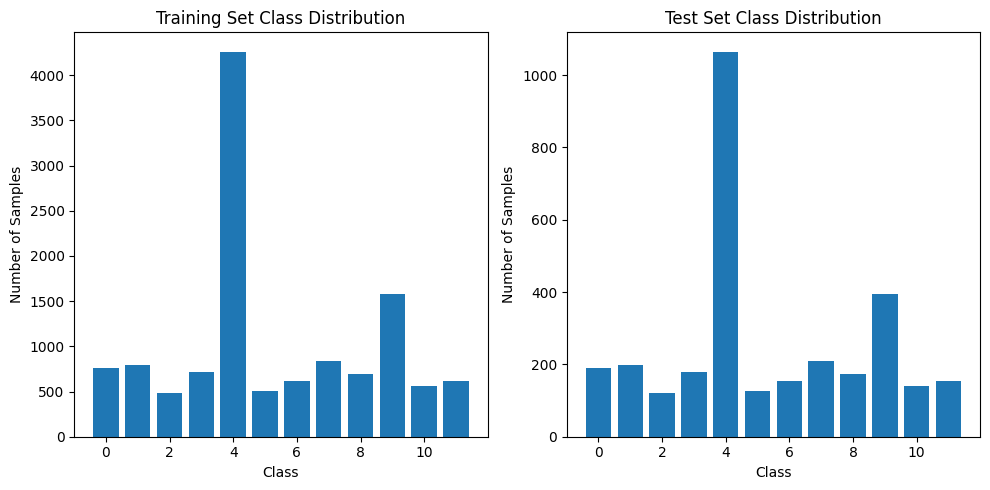

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# training set class distribution
axes[0].bar(train_class_counts.keys(), train_class_counts.values())
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')

# test set class distribution
axes[1].bar(val_class_counts.keys(), val_class_counts.values())
axes[1].set_title('Test Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

Sample Images

In [18]:
garbage_class = {
    '1': 'battery', '2': 'biological', '3': 'brown-glass', '4': 'cardboard', '5': 'clothes', '6': 'green-glass',
    '7': 'metal', '8': 'paper', '9': 'plastic', '10': 'shoes', '11': 'trash', '12': 'white-glass'}

def imshow(img_tensor, ax, label):
    """ Utility function to display an image tensor with a caption. """
    if img_tensor.shape[0] == 3:  # Check if it's an RGB image
        ax.imshow(img_tensor.permute(1, 2, 0))  # Reorder dimensions to (height, width, channels)
    else:
        ax.imshow(img_tensor[0], cmap='gray')  # Display the first channel (grayscale)
    ax.axis('off')
    ax.set_title(label, fontsize=10)

def show_images_batch(images_batch, labels):
    """
    Display a batch of images in a grid with labels.
    """

    batch_size = images_batch.shape[0]
    grid_cols = int(np.ceil(np.sqrt(batch_size)))
    grid_rows = int(np.ceil(batch_size / grid_cols))  # Ensure all images fit in the grid

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2.5, grid_rows * 2.5))
    if grid_rows * grid_cols == 1:  # Special case for single image
        axes = [axes]  # Make it iterable

    # Check if axes is still not iterable
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for i in range(grid_rows * grid_cols):
        ax = axes.flatten()[i]
        if i < batch_size:
            # imshow(images_batch[i], ax, labels[i].item())
            imshow(images_batch[i], ax, garbage_class[str(labels[i].item() + 1)])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

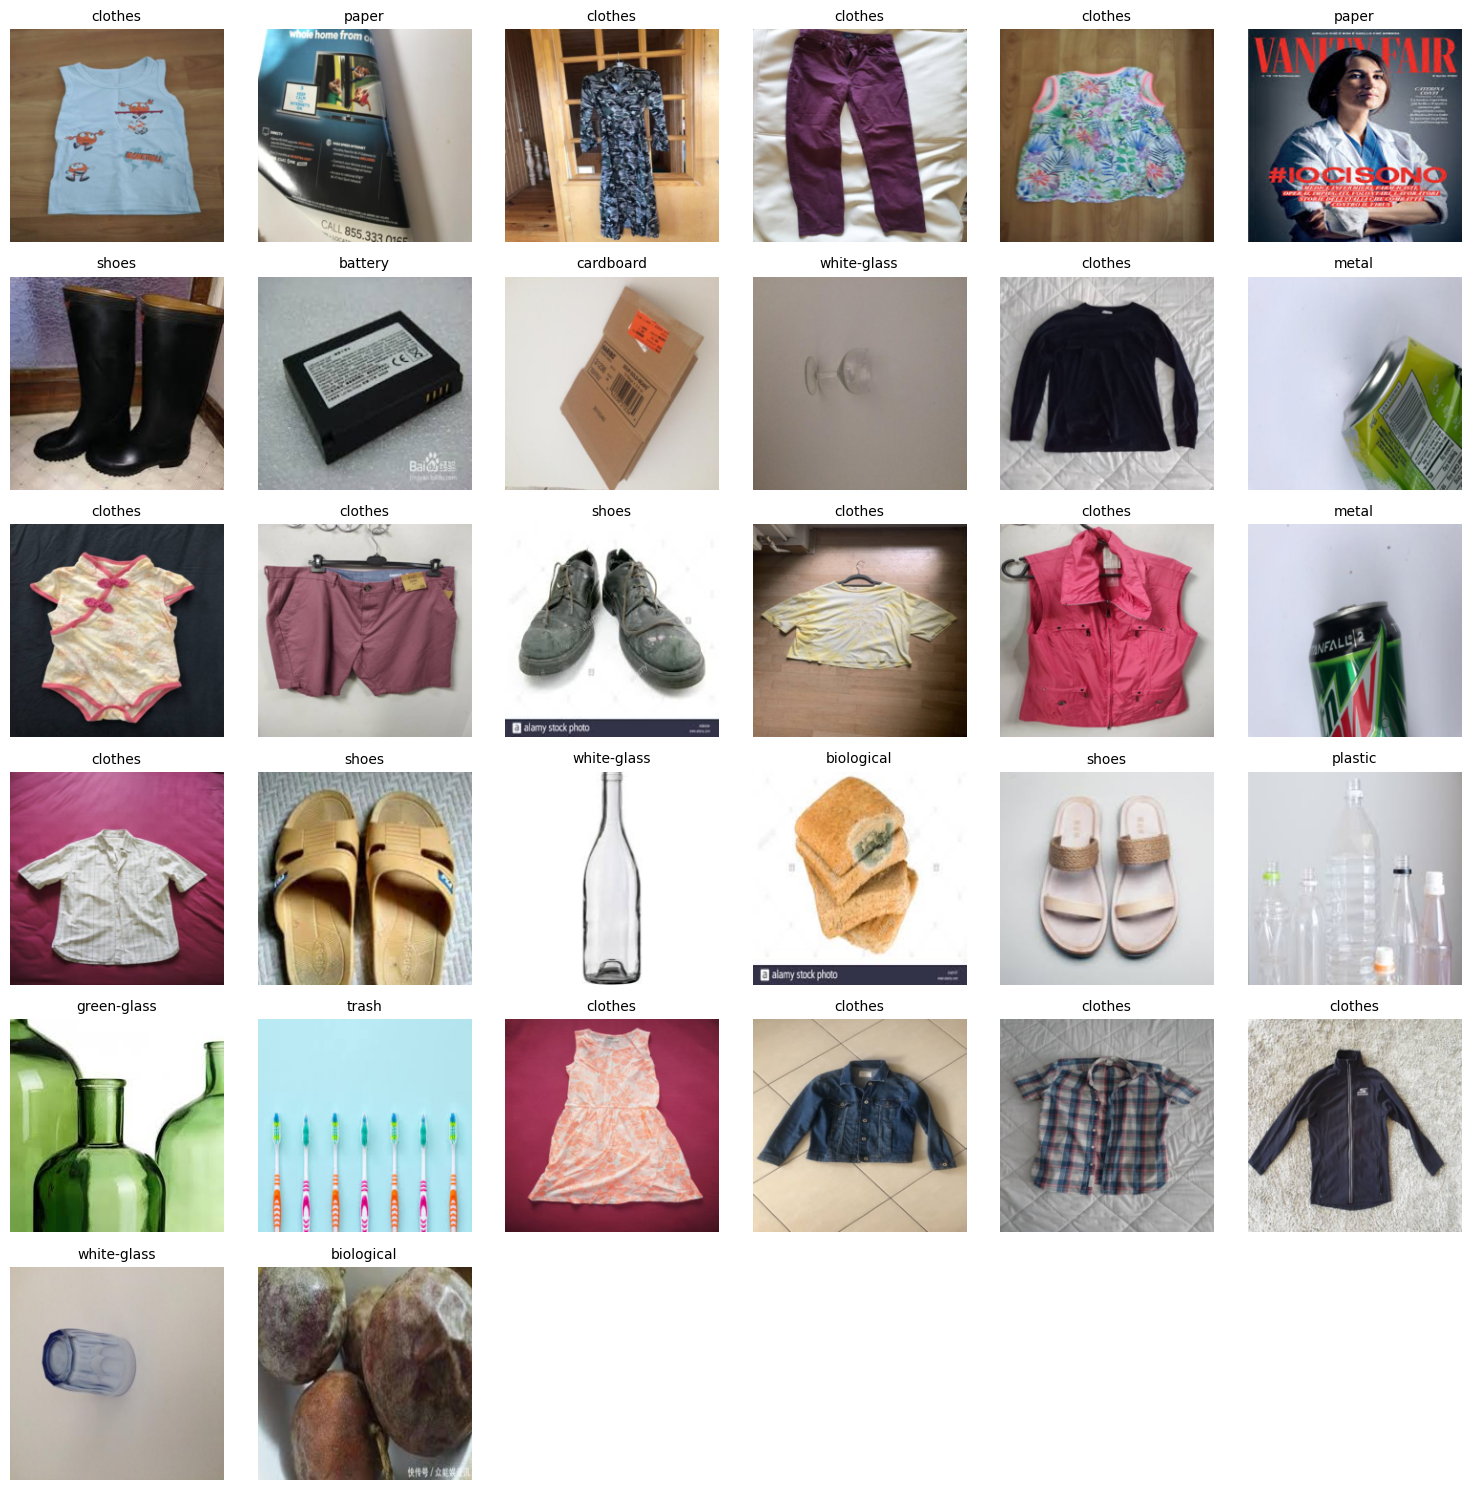

In [19]:
for idx, data in enumerate(train_loader):
  show_images_batch(images_batch=data[0], labels=data[1])
  break

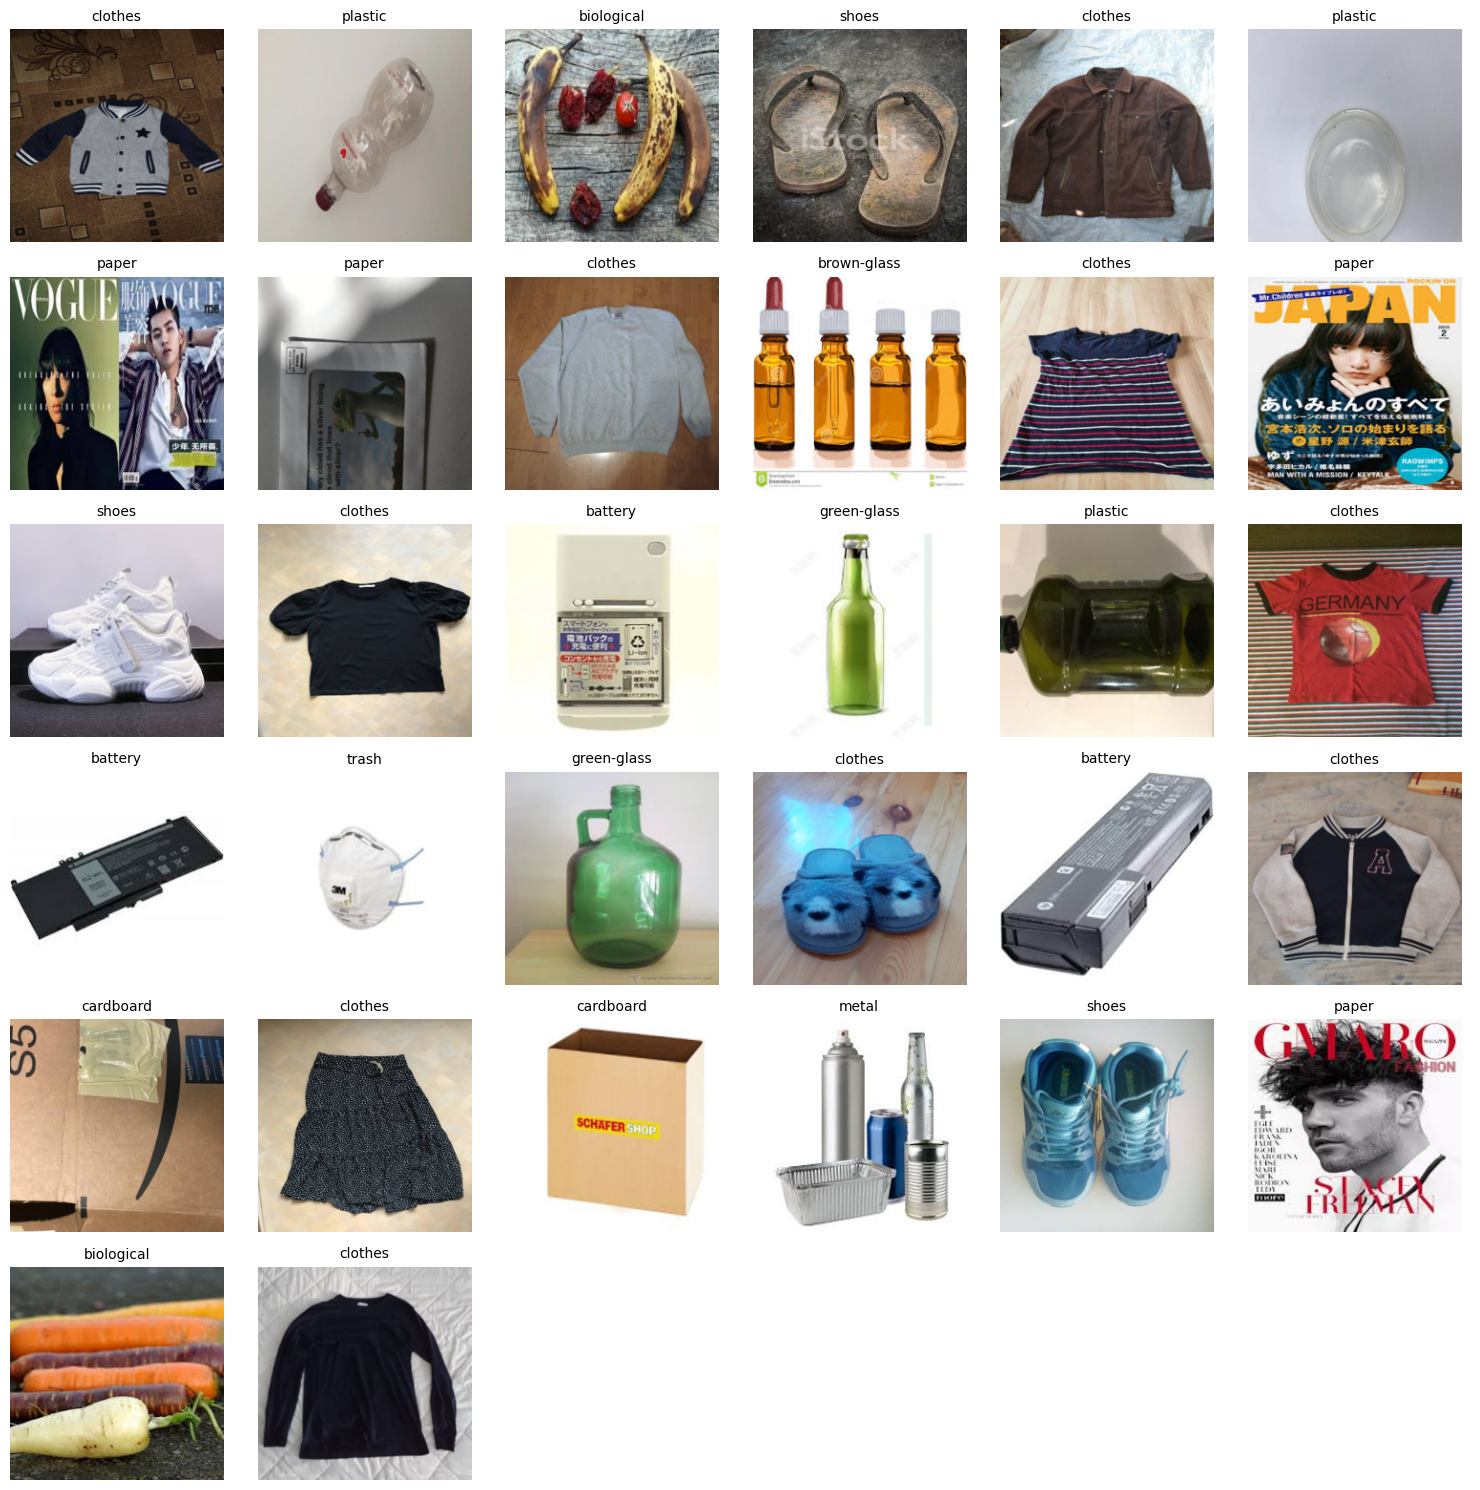

In [20]:
for idx, data in enumerate(val_loader):
  show_images_batch(images_batch=data[0], labels=data[1])
  break

Transfer Learning

In [21]:
resnet_model = torchvision.models.resnet50(weights='IMAGENET1K_V1').cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


In [22]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Changing output layer

In [23]:
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
resnet_model.fc = nn.Linear(2048, 12)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet_model.parameters(), lr=learning_rate)

resnet_model = resnet_model.cuda()

In [25]:
resnet_model = resnet_model.cuda()

Model Evaluation without modification

In [26]:
val_running_loss = 0.0
val_running_accuracy = 0.0

idx = 0
for idx, data in enumerate(val_loader):

  images, labels = data
  images = images.cuda()
  labels = labels.cuda()

  pred = resnet_model(images)

  loss = loss_fn(pred, labels)

  val_running_loss += loss.item()

  _, pred_arr = torch.max(pred.detach(), 1)
  label_arr = labels.cpu().numpy()

  val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  if idx == 10:
    break

print(f"Validation Loss is {val_running_loss}")
print(f"Validation Accuracy is {val_running_accuracy/(idx+1)}")

Validation Loss is 28.663963317871094
Validation Accuracy is 0.02556818181818182


retrain only output layer

In [27]:
# all the layers, parameters, weights and bias shown using .parameter()
# .requires_grad_ = False (cannot calculate the backpropagation, weight will not be changed (freeze the model))
for p in resnet_model.parameters():
  p.requires_grad = False

In [28]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [29]:
resnet_model.fc = nn.Linear(2048, 12)

In [30]:
resnet_model = resnet_model.cuda()

In [31]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [32]:
best_val_accuracy = 0
for epoch_idx in range(num_epoch):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    pred = resnet_model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()
    # training at last layer only

    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")

388it [40:48,  6.31s/it]

Training Loss at epoch 0 is 934.5757818222046
Training Accuracy at epoch 0 is 0.23092323269513992



388it [01:19,  4.87it/s]

Training Loss at epoch 1 is 935.2493517398834
Training Accuracy at epoch 1 is 0.22797772459499263



388it [01:19,  4.90it/s]

Training Loss at epoch 2 is 934.9907898902893
Training Accuracy at epoch 2 is 0.23309784609720177



388it [01:19,  4.88it/s]

Training Loss at epoch 3 is 935.2214887142181
Training Accuracy at epoch 3 is 0.22518179307805594



388it [01:20,  4.84it/s]

Training Loss at epoch 4 is 934.9638547897339
Training Accuracy at epoch 4 is 0.2313029270986745



388it [01:19,  4.85it/s]

Training Loss at epoch 5 is 934.8084967136383
Training Accuracy at epoch 5 is 0.2292548784977909



388it [01:18,  4.93it/s]

Training Loss at epoch 6 is 934.8105297088623
Training Accuracy at epoch 6 is 0.2301638438880707



388it [01:19,  4.90it/s]

Training Loss at epoch 7 is 934.7584805488586
Training Accuracy at epoch 7 is 0.23140648011782033



388it [01:19,  4.91it/s]

Training Loss at epoch 8 is 934.7637937068939
Training Accuracy at epoch 8 is 0.22840344256259204



388it [01:19,  4.86it/s]

Training Loss at epoch 9 is 934.8682622909546
Training Accuracy at epoch 9 is 0.23075064432989692


retraining more layers

In [33]:
for n, p in resnet_model.named_parameters():
  print(n)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [34]:
for p in resnet_model.named_parameters():
  # print(p[0])
  if 'layer4' in p[0]:
    p[1].requires_grad = True

In [35]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [36]:
best_val_accuracy = 0
for epoch_idx in range(num_epoch):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    pred = resnet_model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()


    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")

388it [01:23,  4.65it/s]

Training Loss at epoch 0 is 380.36484022438526
Training Accuracy at epoch 0 is 0.7980370949926362



388it [01:23,  4.63it/s]


Training Loss at epoch 1 is 110.75071505084634
Training Accuracy at epoch 1 is 0.9323223490427099


388it [01:23,  4.66it/s]

Training Loss at epoch 2 is 68.02275383099914
Training Accuracy at epoch 2 is 0.9567378497790869



388it [01:25,  4.56it/s]

Training Loss at epoch 3 is 46.87827271595597
Training Accuracy at epoch 3 is 0.9710741899852725



388it [01:27,  4.44it/s]


Training Loss at epoch 4 is 33.45013978332281
Training Accuracy at epoch 4 is 0.9797036082474226


388it [01:22,  4.70it/s]

Training Loss at epoch 5 is 23.94287183508277
Training Accuracy at epoch 5 is 0.9886436855670103



388it [01:24,  4.62it/s]

Training Loss at epoch 6 is 17.105044242925942
Training Accuracy at epoch 6 is 0.9927512886597938



388it [01:25,  4.56it/s]

Training Loss at epoch 7 is 12.79703653557226
Training Accuracy at epoch 7 is 0.995006443298969



388it [01:24,  4.61it/s]

Training Loss at epoch 8 is 11.765647565247491
Training Accuracy at epoch 8 is 0.9957313144329897



388it [01:24,  4.59it/s]

Training Loss at epoch 9 is 7.727874926757067
Training Accuracy at epoch 9 is 0.9982280927835051


In [37]:
val_running_loss = 0.0
val_running_accuracy = 0.0
idx = 0
for idx, data in enumerate(val_loader):


  images, labels = data
  images = images.cuda()
  labels = labels.cuda()

  pred = resnet_model(images)

  loss = loss_fn(pred, labels)

  val_running_loss += loss.item()

  _, pred_arr = torch.max(pred.detach(), 1)
  label_arr = labels.cpu().numpy()

  val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())


  if idx == 10:
    break

print(f"Validation Loss is {val_running_loss}")
print(f"Validation Accuracy is {val_running_accuracy/(idx+1)}")

Validation Loss is 1.9043741980567575
Validation Accuracy is 0.9488636363636364


Plotting Validation Loss/ Accuracy Curves

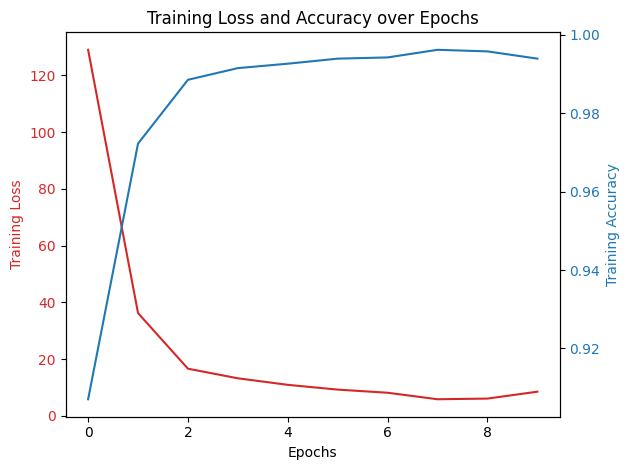

In [38]:
import matplotlib.pyplot as plt

# Data from your training output
epochs = list(range(10))  # Assuming 10 epochs
training_loss = [
    128.9614231940359, 36.21150576369837, 16.62346500949934,
    13.236832838621922, 10.936710711801425, 9.254449758096598,
    8.151131055201404, 5.8591351983486675, 6.095107836124953,
    8.523429761058651
]
training_accuracy = [
    0.9070439064801178, 0.9722823085419735, 0.9885631443298969,
    0.9915431701030928, 0.9926707474226805, 0.9939594072164949,
    0.9942700662739323, 0.9962145618556701, 0.9958118556701031,
    0.9939594072164949
]

# Create a figure with two subplots
fig, ax1 = plt.subplots()

# Plot training loss
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(epochs, training_loss, color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for training accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Training Accuracy', color=color)
ax2.plot(epochs, training_accuracy, color=color, label='Training Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout adjustments
plt.title('Training Loss and Accuracy over Epochs')
fig.tight_layout()
plt.show()

In [ ]:
# # Plot training metrics and log history of training
# epochs = list(range(10))
# historyplt.figure(figsize= (20, 8))
# plt.style.use('fivethirtyeight')

# # plot two graphs in one space for ease of comparison

# plt.subplot(1, 2, 1)
# plt.plot(Epochs, training_loss, 'r', label= 'Training loss')
# plt.plot(Epochs, val_running_loss, 'g', label= 'Validation loss')
# plt.scatter(index_loss+ 1, val_lowest, s= 150, c= 'blue', label= loss_label)
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # plot the training and testing accuracy metrices

# plt.subplot(1, 2, 2)
# plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
# plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
# plt.scatter(index_acc+ 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout
# plt.show()

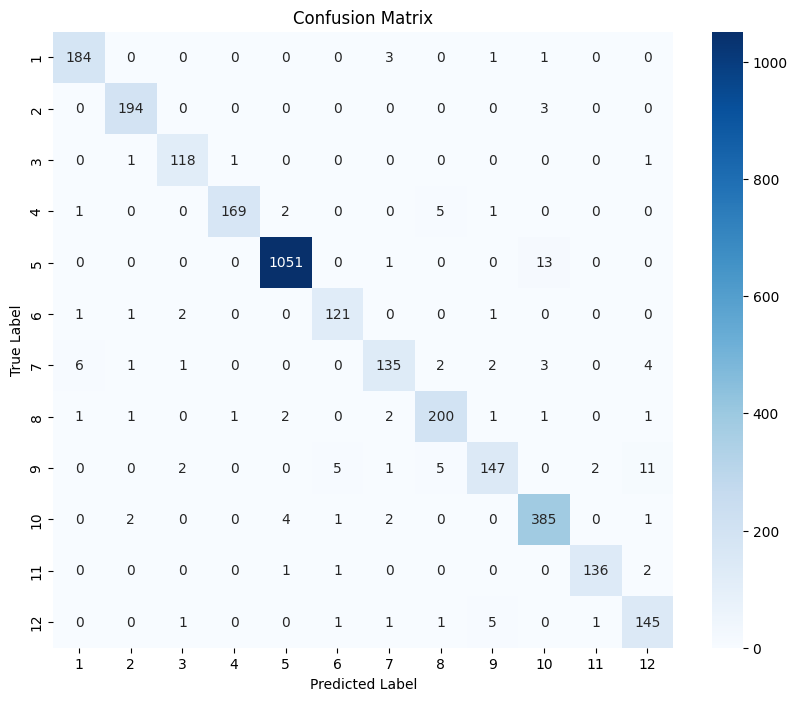

In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_labels = []
all_preds = []

for idx, data in enumerate(val_loader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    pred = resnet_model(images)

    _, pred_arr = torch.max(pred, 1)

    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(pred_arr.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=garbage_class, yticklabels=garbage_class)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [48]:
torch.save(resnet_model, 'garbage_classifier.pt')

In [46]:
import os

# Define your model save path
save_path = '/content/drive/MyDrive/Colab Notebooks/garbage_classification'

# Model and weights save IDs
model_name = "garbage_classifier"
accuracy = 94.88  # Example accuracy; replace with your actual test accuracy
save_id = f'{model_name}-accuracy-{accuracy:.2f}.pt'  # Save file name based on accuracy

# Full model save location
model_save_loc = os.path.join(save_path, save_id)

# Save the model (architecture + weights)
torch.save(resnet_model, model_save_loc)  # Here, only the model and the location is needed
print(f'Model saved as {model_save_loc}')

# Alternatively, save just the model weights (state_dict)
weights_save_id = f'{model_name}-weights.pt'
weights_save_loc = os.path.join(save_path, weights_save_id)

# Save the weights (state_dict)
torch.save(resnet_model.state_dict(), weights_save_loc)  # Only the state_dict and location are needed
print(f'Weights saved as {weights_save_loc}')


Model saved as /content/drive/MyDrive/Colab Notebooks/garbage_classification/garbage_classifier-accuracy-94.88.pt
Weights saved as /content/drive/MyDrive/Colab Notebooks/garbage_classification/garbage_classifier-weights.pt
